# Overview

In this notebook, we will build a predictive model for the Prosper loan data. We will import the processed data from our previous notebook [here](http://localhost:8888/notebooks/Forecasting%20credit%20risk%20using%20logistic%20regression.ipynb#ProsperScore).

Our goal is to build perform a binary classification of the loan default/non-default variables using logistic regression.

In [25]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.pipeline import Pipeline

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import (confusion_matrix, classification_report)

import pickle

### Loading the Data

In [2]:
x_train = pd.read_csv('loan_data_inputs_train.csv')
y_train = pd.read_csv('loan_data_targets_train.csv')
x_test = pd.read_csv('loan_data_inputs_test.csv')
y_test = pd.read_csv('loan_data_targets_test.csv')

In [3]:
print("Train data:", x_train.shape, y_train.shape)
print("Test data:", x_test.shape, y_test.shape)

Train data: (40423, 77) (40423, 1)
Test data: (13475, 77) (13475, 1)


#### Reshape the target datasets

In [4]:
y_train = y_train.values.reshape(-1,)
y_test = y_test.values.reshape(-1,)

In [5]:
#print new shape
print("Train data:", x_train.shape, y_train.shape)
print("Test data:", x_test.shape, y_test.shape)

Train data: (40423, 77) (40423,)
Test data: (13475, 77) (13475,)


In [6]:
#a look at few rows of input train data
x_train.head()

,IncomeRange,IncomeVerifiable,IsBorrowerHomeowner,DebtToIncomeRatio,AvailableBankcardCredit,EmploymentStatus,LoanStatus,Term,LoanOriginalAmount,ProsperRating (Alpha),...,DebtToIncomeRatio:0.244-0.296,DebtToIncomeRatio:0.296-0.4,DebtToIncomeRatio>0.4,AvailableBankcardCreditFactor,AvailableBankcardCredit:<8.5k,AvailableBankcardCredit:8.5k-15.5k,AvailableBankcardCredit:15.5k-21k,AvailableBankcardCredit:21k-25.5k,AvailableBankcardCredit:25.5k-30k,AvailableBankcardCredit>30k
0,"$25,000-49,999",True,False,0.07,1645.0,Employed,Chargedoff,60,3500,E,...,0,0,0,"(-498.374, 9967.48]",1,0,0,0,0,0
1,"$100,000+",True,True,0.23,10704.0,Employed,Current,60,15000,A,...,0,0,0,"(9967.48, 19934.96]",0,1,0,0,0,0
2,"$100,000+",True,False,0.18,24063.0,Employed,Current,60,25000,A,...,0,0,0,"(19934.96, 29902.44]",0,0,0,1,0,0
3,"$50,000-74,999",True,False,0.20,47304.0,Employed,Current,36,4000,D,...,0,0,0,"(39869.92, 49837.4]",0,0,0,0,0,1
4,"$50,000-74,999",True,False,0.12,2630.0,Employed,Current,60,15000,C,...,0,0,0,"(-498.374, 9967.48]",1,0,0,0,0,0


In [7]:
#a look at few rows of input test data
x_test.head()

,IncomeRange,IncomeVerifiable,IsBorrowerHomeowner,DebtToIncomeRatio,AvailableBankcardCredit,EmploymentStatus,LoanStatus,Term,LoanOriginalAmount,ProsperRating (Alpha),...,DebtToIncomeRatio:0.244-0.296,DebtToIncomeRatio:0.296-0.4,DebtToIncomeRatio>0.4,AvailableBankcardCreditFactor,AvailableBankcardCredit:<8.5k,AvailableBankcardCredit:8.5k-15.5k,AvailableBankcardCredit:15.5k-21k,AvailableBankcardCredit:21k-25.5k,AvailableBankcardCredit:25.5k-30k,AvailableBankcardCredit>30k
0,"$25,000-49,999",True,False,0.35,0.0,Employed,Current,36,2500,HR,...,0,1,0,"(-360.0, 7200.0]",1,0,0,0,0,0
1,"$1-24,999",False,False,NaN,115.0,Self-employed,Current,60,12000,D,...,0,0,0,"(-360.0, 7200.0]",1,0,0,0,0,0
2,"$50,000-74,999",True,True,0.42,12145.0,Employed,Current,36,15000,C,...,0,0,1,"(7200.0, 14400.0]",0,1,0,0,0,0
3,"$75,000-99,999",True,False,0.13,200.0,Employed,Current,36,4000,B,...,0,0,0,"(-360.0, 7200.0]",1,0,0,0,0,0
4,"$75,000-99,999",True,False,0.18,378.0,Employed,Completed,36,4000,D,...,0,0,0,"(-360.0, 7200.0]",1,0,0,0,0,0


### Selecting the Features

#### input Training data

In [8]:
x_train.columns.values

array(['IncomeRange', 'IncomeVerifiable', 'IsBorrowerHomeowner',
       'DebtToIncomeRatio', 'AvailableBankcardCredit', 'EmploymentStatus',
       'LoanStatus', 'Term', 'LoanOriginalAmount',
       'ProsperRating (Alpha)', 'ProsperScore', 'BorrowerRate',
       'CreditScoreRange', 'IncomeRange:$0', 'IncomeRange:$1-24,999',
       'IncomeRange:$100,000+', 'IncomeRange:$25,000-49,999',
       'IncomeRange:$50,000-74,999', 'IncomeRange:$75,000-99,999',
       'IncomeRange:Not employed', 'EmploymentStatus:Employed',
       'EmploymentStatus:Full-time', 'EmploymentStatus:Not employed',
       'EmploymentStatus:Other', 'EmploymentStatus:Part-time',
       'EmploymentStatus:Retired', 'EmploymentStatus:Self-employed',
       'CreditScoreRange:Exceptional (800+)',
       'CreditScoreRange:Fair (600-679)',
       'CreditScoreRange:Good (680-739)',
       'CreditScoreRange:Very Good (740-799)', 'IncomeVerifiable:False',
       'IncomeVerifiable:True', 'IsBorrowerHomeowner:False',
       'IsBorrow

In [9]:
x_train_with_ref_cat = x_train[['IncomeRange:$0', 'IncomeRange:$1-24,999',
       'IncomeRange:$100,000+', 'IncomeRange:$25,000-49,999',
       'IncomeRange:$50,000-74,999', 'IncomeRange:$75,000-99,999',
       'IncomeRange:Not employed', 'EmploymentStatus:Employed',
       'CreditScoreRange:Exceptional (800+)',
       'CreditScoreRange:Fair (600-679)',
       'CreditScoreRange:Good (680-739)',
       'CreditScoreRange:Very Good (740-799)', 'IncomeVerifiable:False',
       'IncomeVerifiable:True', 'IsBorrowerHomeowner:False',
       'IsBorrowerHomeowner:True', 'ProsperRating (Alpha):A',
       'ProsperRating (Alpha):AA', 'ProsperRating (Alpha):B',
       'ProsperRating (Alpha):C', 'ProsperRating (Alpha):D',
       'ProsperRating (Alpha):E', 'ProsperRating (Alpha):HR',
       'EmploymentStatus:Other__self_employed__full_time',
       'EmploymentStatus:Not_employed__part_time__retired', 'Term:12',
       'Term:36', 'Term:60', 'ProsperScore:1', 'ProsperScore:2-5',
       'ProsperScore:6-8', 'ProsperScore:9-11',
       'BorrowerRate:<0.111', 'BorrowerRate:0.111, 0.188',
       'BorrowerRate:0.188, 0.243', 'BorrowerRate:0.243-0.292',
       'BorrowerRate:>0.292',
       'LoanOriginalAmount:<7.5K', 'LoanOriginalAmount:7.5K-15K',
       'LoanOriginalAmount:15K-20.4K', 'LoanOriginalAmount:20.4K-24.3k',
       'LoanOriginalAmount>24.3k',
       'DebtToIncomeRatio:Missing', 'DebtToIncomeRatio:<0.088',
       'DebtToIncomeRatio:0.088-0.244', 'DebtToIncomeRatio:0.244-0.296',
       'DebtToIncomeRatio:0.296-0.4', 'DebtToIncomeRatio>0.4',
        'AvailableBankcardCredit:<8.5k',
       'AvailableBankcardCredit:8.5k-15.5k',
       'AvailableBankcardCredit:15.5k-21k',
       'AvailableBankcardCredit:21k-25.5k',
       'AvailableBankcardCredit:25.5k-30k', 'AvailableBankcardCredit>30k']]


#============================================================================================
#list of reference variable categories with lowest weight of evidience 

ref_categories = ['IncomeRange:$0', 'EmploymentStatus:Not_employed__part_time__retired','CreditScoreRange:Fair (600-679)',
                 'Term:60','IsBorrowerHomeowner:False','IncomeVerifiable:False',
                  'BorrowerRate:<0.111','ProsperRating (Alpha):HR','LoanOriginalAmount:<7.5K',
                  'DebtToIncomeRatio:<0.088', 'AvailableBankcardCredit:<8.5k','ProsperScore:1',
                 'EmploymentStatus:Not_employed__part_time__retired']

In [10]:
inputs_train = x_train_with_ref_cat.drop(ref_categories, axis = 1)
inputs_train.shape

(40423, 42)

In [11]:
sum(inputs_train.dtypes==int)

42

So we have 42 features in the input training data and are numeric, a desirable data type for our ML model.

#### Input Testing data

In [12]:
# Here, from the dataframe with inputs for testing, we keep the same variables that we used in our final PD model.


x_test_with_ref_cat = x_test[['IncomeRange:$0', 'IncomeRange:$1-24,999',
       'IncomeRange:$100,000+', 'IncomeRange:$25,000-49,999',
       'IncomeRange:$50,000-74,999', 'IncomeRange:$75,000-99,999',
       'IncomeRange:Not employed', 'EmploymentStatus:Employed',
       'CreditScoreRange:Exceptional (800+)',
       'CreditScoreRange:Fair (600-679)',
       'CreditScoreRange:Good (680-739)',
       'CreditScoreRange:Very Good (740-799)', 'IncomeVerifiable:False',
       'IncomeVerifiable:True', 'IsBorrowerHomeowner:False',
       'IsBorrowerHomeowner:True', 'ProsperRating (Alpha):A',
       'ProsperRating (Alpha):AA', 'ProsperRating (Alpha):B',
       'ProsperRating (Alpha):C', 'ProsperRating (Alpha):D',
       'ProsperRating (Alpha):E', 'ProsperRating (Alpha):HR',
       'EmploymentStatus:Other__self_employed__full_time',
       'EmploymentStatus:Not_employed__part_time__retired', 'Term:12',
       'Term:36', 'Term:60', 'ProsperScore:1', 'ProsperScore:2-5',
       'ProsperScore:6-8', 'ProsperScore:9-11',
       'BorrowerRate:<0.111', 'BorrowerRate:0.111, 0.188',
       'BorrowerRate:0.188, 0.243', 'BorrowerRate:0.243-0.292',
       'BorrowerRate:>0.292',
       'LoanOriginalAmount:<7.5K', 'LoanOriginalAmount:7.5K-15K',
       'LoanOriginalAmount:15K-20.4K', 'LoanOriginalAmount:20.4K-24.3k',
       'LoanOriginalAmount>24.3k',
       'DebtToIncomeRatio:Missing', 'DebtToIncomeRatio:<0.088',
       'DebtToIncomeRatio:0.088-0.244', 'DebtToIncomeRatio:0.244-0.296',
       'DebtToIncomeRatio:0.296-0.4', 'DebtToIncomeRatio>0.4',
        'AvailableBankcardCredit:<8.5k',
       'AvailableBankcardCredit:8.5k-15.5k',
       'AvailableBankcardCredit:15.5k-21k',
       'AvailableBankcardCredit:21k-25.5k',
       'AvailableBankcardCredit:25.5k-30k', 'AvailableBankcardCredit>30k']]




ref_categories = ['IncomeRange:$0', 'EmploymentStatus:Not_employed__part_time__retired','CreditScoreRange:Fair (600-679)',
                 'Term:60','IsBorrowerHomeowner:False','IncomeVerifiable:False',
                  'BorrowerRate:<0.111','ProsperRating (Alpha):HR','LoanOriginalAmount:<7.5K',
                  'DebtToIncomeRatio:<0.088', 'AvailableBankcardCredit:<8.5k','ProsperScore:1',
                 'EmploymentStatus:Not_employed__part_time__retired']

In [13]:
inputs_test = x_test_with_ref_cat.drop(ref_categories, axis = 1)
inputs_test.shape

(13475, 42)

In [14]:
sum(inputs_train.dtypes==int)

42

In [15]:
(inputs_test.columns == inputs_train.columns)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

So we have 42 features in the input testing data and all are numeric. We have also confirmed that the features n x_train==x_test

# PD Model Estimation

## Logistic Regression

In [16]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [17]:
def performance_report(model,X_true,y_true):
    """
    Function to generate classification report on a model
    INPUT: Model, true data sets, that is X_test & y_test data sets
    OUTPUT: Prints the f1 score, precision and recall for each output category
    """
    y_pred = model.predict(X_true)
    
    print(classification_report(y_true, y_pred))
   

In [45]:
def confusion_mat(model,X_true,y_true):
    y_pred = model.predict(X_true)
    cm = confusion_matrix(y_true, y_pred)
    conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
    plt.figure(figsize = (8,5))
    sb.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1]}

In [46]:
def confusion_mat_with_gridsearch(model,X_true,y_true):
    y_pred = model.best_estimator_.predict(X_true)
    cm = confusion_matrix(y_true, y_pred)
    conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
    plt.figure(figsize = (8,5))
    sb.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1]}

### Build Logistic regression pipeline

In [19]:
LogReg_pipeline = Pipeline([
    ('clf', LogisticRegression())
])



In [20]:
LogReg_pipeline.fit(inputs_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [21]:
#test the model
performance_report(LogReg_pipeline, inputs_test, y_test)

              precision    recall  f1-score   support

           0       0.50      0.00      0.01       969
           1       0.93      1.00      0.96     12506

    accuracy                           0.93     13475
   macro avg       0.71      0.50      0.48     13475
weighted avg       0.90      0.93      0.89     13475



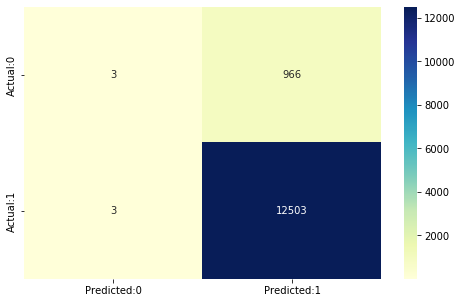

In [27]:
confusion_mat(LogReg_pipeline, inputs_test, y_test)

So we see here that our model predicts good borrowers with 93% precision, and bad borrowers with precision of 50%

### Improve the model

Before we use grid search, we want to know which independent variables contribute to predicting borrower default and which dont? The accepted approach is to check the statistical significance of coeeficients of each dummy variables. We look at P-value, then we will alter the fit model with newly selected features.

### Build a Logistic Regression Model with P-Values


In [28]:
inputs_train['intercept']= 1
logit_mod =sm.Logit(y_train,inputs_train)

#fit the model
results = logit_mod.fit()

#get summary statistics
results.summary2() 

Optimization terminated successfully.
         Current function value: 0.222125
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                         Results: Logit
=================================================================================================
Model:                          Logit                      Pseudo R-squared:           0.129     
Dependent Variable:             y                          AIC:                        18043.9306
Date:                           2022-03-06 07:18           BIC:                        18414.0382
No. Observations:               40423                      Log-Likelihood:             -8979.0   
Df Model:                       42                         LL-Null:                    -10308.   
Df Residuals:                   40380                      LLR p-value:                0.0000    
Converged:                      1.0000                     Scale:                      1.0000    
No. Iterations:                 8.0000                                                           
-------------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------------------------
IncomeRange:$1-24,999                             0.0694   0.7172   0.0968 0.9229 -1.3363  1.4751
IncomeRange:$100,000+                             0.9817   0.7177   1.3678 0.1714 -0.4250  2.3884
IncomeRange:$25,000-49,999                        0.2258   0.7153   0.3157 0.7522 -1.1762  1.6278
IncomeRange:$50,000-74,999                        0.5893   0.7159   0.8231 0.4105 -0.8139  1.9924
IncomeRange:$75,000-99,999                        0.7496   0.7172   1.0453 0.2959 -0.6560  2.1553
IncomeRange:Not employed                          0.3682   0.8274   0.4450 0.6563 -1.2535  1.9899
EmploymentStatus:Employed                         0.3258   0.3977   0.8194 0.4126 -0.4536  1.1053
CreditScoreRange:Exceptional (800+)              -0.2824   0.1528  -1.8483 0.0646 -0.5819  0.0171
CreditScoreRange:Good (680-739)                  -0.0513   0.0490  -1.0477 0.2948 -0.1474  0.0447
CreditScoreRange:Very Good (740-799)             -0.1182   0.0717  -1.6493 0.0991 -0.2587  0.0223
IncomeVerifiable:True                            -0.8771   0.8653  -1.0137 0.3107 -2.5730  0.8188
IsBorrowerHomeowner:True                         -0.0200   0.0444  -0.4498 0.6528 -0.1071  0.0671
ProsperRating (Alpha):A                          -0.9435   0.2214  -4.2615 0.0000 -1.3775 -0.5096
ProsperRating (Alpha):AA                         -0.5878   0.3316  -1.7725 0.0763 -1.2377  0.0622
ProsperRating (Alpha):B                          -1.0957   0.1938  -5.6550 0.0000 -1.4755 -0.7160
ProsperRating (Alpha):C                          -0.6795   0.1544  -4.4008 0.0000 -0.9821 -0.3769
ProsperRating (Alpha):D                          -0.4934   0.1318  -3.7442 0.0002 -0.7516 -0.2351
ProsperRating (Alpha):E                           0.3670   0.0826   4.4439 0.0000  0.2052  0.5289
EmploymentStatus:Other__self_employed__full_time  0.2765   0.4003   0.6908 0.4897 -0.5080  1.0610
Term:12                                          -0.4166   0.1950  -2.1369 0.0326 -0.7988 -0.0345
Term:36                                           0.0978   0.0524   1.8680 0.0618 -0.0048  0.2005
ProsperScore:2-5                                  0.9527   0.1344   7.0862 0.0000  0.6892  1.2162
ProsperScore:6-8                                  0.5540   0.1404   3.9444 0.0001  0.2787  0.8292
ProsperScore:9-11                                 0.6573   0.1841   3.5709 0.0004  0.2965  1.0181
BorrowerRate:0.111, 0.188                        -0.6099   0.1688  -3.6119 0.0003 -0.9408 -0.2789
BorrowerRate:0.188, 0.243                        -1.8586   0.2001  -9.2865 0.0000 -2.2509 -1.4663
BorrowerRate:0.243-0.292                         -2.8858   0.2158 -13.3753 0.0000 -3.3087 -2.4630
BorrowerRate:>0.292                              -4.0072   0.2439 -16.432

### Selecting features

Here we will select only features that are statistically significant. That is with p-values <0.05. These features are believed to have strong predicting power.

In [29]:
#create a dataframe of all p-values
pvalue = pd.DataFrame(results.pvalues,columns={'p_value'},)

#a loop to display attributes with P value higher than the preferred alpha(5%) 

pvs=[]
for i in range (0, len(pvalue["p_value"])):
    if pvalue['p_value'][i] < 0.05:
        pvs.append(pvalue.index[i])
    if 'const' in pvs:
         pvs.remove('const')
    else:
         pvs 
print(pvs)
print(len(pvs))

['ProsperRating (Alpha):A', 'ProsperRating (Alpha):B', 'ProsperRating (Alpha):C', 'ProsperRating (Alpha):D', 'ProsperRating (Alpha):E', 'Term:12', 'ProsperScore:2-5', 'ProsperScore:6-8', 'ProsperScore:9-11', 'BorrowerRate:0.111, 0.188', 'BorrowerRate:0.188, 0.243', 'BorrowerRate:0.243-0.292', 'BorrowerRate:>0.292', 'DebtToIncomeRatio:0.088-0.244', 'DebtToIncomeRatio:0.244-0.296', 'DebtToIncomeRatio:0.296-0.4', 'DebtToIncomeRatio>0.4', 'AvailableBankcardCredit:8.5k-15.5k', 'AvailableBankcardCredit:15.5k-21k', 'AvailableBankcardCredit:21k-25.5k', 'AvailableBankcardCredit:25.5k-30k', 'AvailableBankcardCredit>30k', 'intercept']
23


So out of 42 features, only 23 are statistically significant while others have low statistically significant relationship with the probability of default

Let us rebuild these logistic model with these 23 features.

In [30]:
#selecting features
new_inputs_train = inputs_train[['ProsperRating (Alpha):A', 'ProsperRating (Alpha):B', 
                                 'ProsperRating (Alpha):C', 'ProsperRating (Alpha):D', 
                                 'ProsperRating (Alpha):E', 'Term:12', 'ProsperScore:2-5',
                                 'ProsperScore:6-8', 'ProsperScore:9-11', 'BorrowerRate:0.111, 0.188',
                                 'BorrowerRate:0.188, 0.243', 'BorrowerRate:0.243-0.292', 
                                 'BorrowerRate:>0.292', 'DebtToIncomeRatio:0.088-0.244', 
                                 'DebtToIncomeRatio:0.244-0.296', 'DebtToIncomeRatio:0.296-0.4',
                                 'DebtToIncomeRatio>0.4', 'AvailableBankcardCredit:8.5k-15.5k',
                                 'AvailableBankcardCredit:15.5k-21k', 'AvailableBankcardCredit:21k-25.5k',
                                 'AvailableBankcardCredit:25.5k-30k', 'AvailableBankcardCredit>30k']]

#testdata================================
new_inputs_test = inputs_test[['ProsperRating (Alpha):A', 'ProsperRating (Alpha):B', 
                                 'ProsperRating (Alpha):C', 'ProsperRating (Alpha):D', 
                                 'ProsperRating (Alpha):E', 'Term:12', 'ProsperScore:2-5',
                                 'ProsperScore:6-8', 'ProsperScore:9-11', 'BorrowerRate:0.111, 0.188',
                                 'BorrowerRate:0.188, 0.243', 'BorrowerRate:0.243-0.292', 
                                 'BorrowerRate:>0.292', 'DebtToIncomeRatio:0.088-0.244', 
                                 'DebtToIncomeRatio:0.244-0.296', 'DebtToIncomeRatio:0.296-0.4',
                                 'DebtToIncomeRatio>0.4', 'AvailableBankcardCredit:8.5k-15.5k',
                                 'AvailableBankcardCredit:15.5k-21k', 'AvailableBankcardCredit:21k-25.5k',
                                 'AvailableBankcardCredit:25.5k-30k', 'AvailableBankcardCredit>30k']]

In [31]:
LogReg_pipeline.fit(new_inputs_train,y_train)

Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [37]:
#test the model
performance_report(LogReg_pipeline, new_inputs_test, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       969
           1       0.93      1.00      0.96     12506

    accuracy                           0.93     13475
   macro avg       0.46      0.50      0.48     13475
weighted avg       0.86      0.93      0.89     13475



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'tn': 0, 'fp': 969, 'fn': 0, 'tp': 12506}

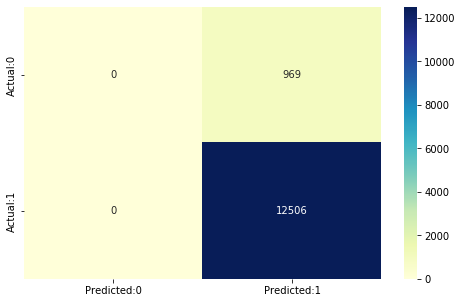

In [41]:
confusion_mat(LogReg_pipeline, new_inputs_test, y_test)

Improving the model with gridsearch

In [33]:
parameters = {
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__max_iter': [1000,1500]
}

#parameters_grid = {'classifier__estimator__n_estimators': [10, 20, 40]}

#f1 = make_scorer(f1_score , average='macro')
cv = GridSearchCV(LogReg_pipeline, param_grid=parameters)

In [34]:
# Find best parameters
cv.fit(new_inputs_train, y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=None,
                                              

In [35]:
#test model
performance_report(cv, new_inputs_test, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       969
           1       0.93      1.00      0.96     12506

    accuracy                           0.93     13475
   macro avg       0.46      0.50      0.48     13475
weighted avg       0.86      0.93      0.89     13475



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'tn': 0, 'fp': 969, 'fn': 0, 'tp': 12506}

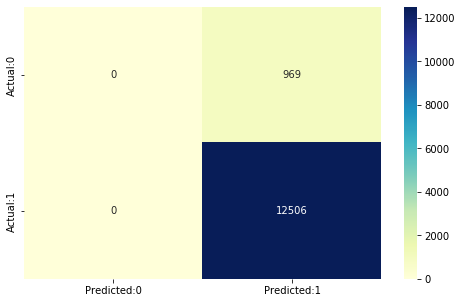

In [47]:
confusion_mat_with_gridsearch(cv, new_inputs_test, y_test)

In [37]:
optimised_model = cv.best_estimator_

In [38]:
optimised_model

Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [45]:
# Pickle best model

with open('prosper_loan_model.pkl', 'wb') as f:
    pickle.dump(optimised_model, f)

### Interpreting the PD model

In [48]:
#print optimised_model.named_steps['clf'].coef_

array([[-0.7149387 , -0.97663694, -0.64156338, -0.46306701,  0.4067268 ,
        -0.34579398,  0.80384459,  0.36936399,  0.54395239, -0.29439693,
        -1.486693  , -2.54451842, -3.58991894,  0.49587851,  0.51671435,
         0.50772248,  0.31560656, -0.21630434, -0.16677352, -0.28535145,
        -0.53556407, -0.25555387]])

In [49]:
optimised_model.named_steps['clf'].intercept_

array([3.85431444])

In [50]:
feature_name = new_inputs_train.columns.values

In [52]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(optimised_model.named_steps['clf'].coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', optimised_model.named_steps['clf'].intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,3.854314
1,ProsperRating (Alpha):A,-0.714939
2,ProsperRating (Alpha):B,-0.976637
3,ProsperRating (Alpha):C,-0.641563
4,ProsperRating (Alpha):D,-0.463067
5,ProsperRating (Alpha):E,0.406727
6,Term:12,-0.345794
7,ProsperScore:2-5,0.803845
8,ProsperScore:6-8,0.369364
9,ProsperScore:9-11,0.543952


In [58]:
summary_table[summary_table['Feature name']!="Intercept"].max()

Feature name     Term:12
Coefficients    0.803845
dtype: object

In [59]:
summary_table[summary_table['Feature name']!="Intercept"].min()

Feature name    AvailableBankcardCredit:15.5k-21k
Coefficients                             -3.58992
dtype: object

### Evaluating and interpreting the model

In [72]:
def probability_default_df(model,X_true,y_true,tr):
    """
    Function to generate probability of good borrowers on a model
    INPUT: Model, true data sets, that is X_true & y_true data sets
    OUTPUT: Prints the target test data and its corresponing probability of being a 
    good borrower 
    """
    y_hat_test = model.best_estimator_.predict(X_true)
    y_hat_test_proba = model.best_estimator_.predict_proba(X_true)
    y_hat_test_proba = y_hat_test_proba[: ][: , 1]
    
    y_test_temp = y_true
    df_actual_predicted_probs = pd.concat([pd.DataFrame(y_test_temp),
                                           pd.DataFrame(y_hat_test_proba)], axis = 1)


    df_actual_predicted_probs.columns = ['y_test', 'y_hat_test_proba']
    df_actual_predicted_probs.index = X_true.index
   
   

    return df_actual_predicted_probs
# Makes the index of one dataframe equal to the index of another dataframe.


    

In [115]:
def conf_mat(tr):
    """A function to give the model's confusion matrix for a given threshold.
    
    INPUT: tr = probability threshold
    """
    df = probability_default_df(cv, new_inputs_test, y_test)
    y_hat_test = cv.best_estimator_.predict(new_inputs_test)
    
    
    df['y_hat_test'] = np.where(df['y_hat_test_proba'] > tr, 1, 0)
    
    return pd.crosstab(df['y_test'], df['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted'])
    #pd.crosstab(df_actual_predicted_probs['y_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

   

In [108]:
#a look at the y_test train and predicted probabilities
df_predict_proba = probability_default_df(cv, new_inputs_test, y_test)
df_predict_proba.head()

,y_test,y_hat_test_proba
0,1,0.828632
1,1,0.838969
2,1,0.932718
3,1,0.969187
4,1,0.941022


### Confusion Matrix

Earlier we saw the confusion matrix for our logistic regression model given as:

In [116]:
conf_mat(0.5)

Predicted,1
Actual,
0,969
1,12506


So here we have pricted the default confusion matrix in sklearn and how it works is that:
an indicator is defined,
- where every observation that has predicted probability greater than the threshold (tr) has a value of 1,
- and every observation that has predicted probability lower than the threshold has a value of 0.

Obviously, all observations that are actually good are predicted to be good, which is a good thing. On the other hand, all observations that are bad are predicted to be good with non predicted to be bad. 

This is a huge problem, 

- first we know our data is purely imbalanced with more than 92% of borrowers being good. Thus 
\begin{align}
\text{Accuracy} = \frac{TP+TN}{(TP+TN+FP+FN) } = \frac{12506}{12506+969}=92.8 \%
\end{align}

where 'TN'= cm[0, 0], 'FP'= cm[0, 1],'FN'= cm[1, 0], and  'TP'= cm[1, 1]}

it turns out under a threshold of 0.5, the model generates a lot of false positives; that is observations that are bad but are being classified as being good. Imagine what would happen if the model was used for making a decision such as granting loans. With this threshold, a lot of bad applicants would be given loans. This is completely unacceptable.

That's what happens when we keep the default threshold since very few people default on their loans. The regression learns that and classifies almost all cases as good.

Let us increase the threshold 


In [117]:
conf_mat(0.9)

Predicted,0,1
Actual,,
0,580,389
1,2773,9733


There are much less false positive predictions, but also much less true positive.
That implies that if a lender uses the model for granting loans under the zero point nine threshold,
they would reduce the number of defaults dramatically but also the number of overall approved applications.
So a zero point nine threshold might be too conservative and may lead to losing business.
Note that when doing credit risk modeling, we want to minimize the risk, but we still want to give
out loans because that's how we make money.
OK, what we saw is that overall accuracy is not the universal measure for a speedy model.
The rates of the true positive predictions, goods that are being correctly classified as goods and
the false positive predictions bands that are incorrectly classified as goods are far more important
than the overall accuracy.
Naturally, this is not an issue that we just came across.
It is well documented and there are different remedies.
One of the more common ways to approach that is to see the rates of the false positive predictions and
the rates of the true positive predictions for all possible thresholds in machine learning.
The Curve, which shows the rate of the true positive predictions, is called receiver operating characteristic
curve or oracy curve.
Every point of that curve actually corresponds to one threshold point that would result in a different
classification of good and bad.
More specifically, each point from the RSI curve corresponds to a different confusion matrix based
on a different classification threshold.
So let's plot the accuracy curve for our model.

### Accuracy and Area under the Curve

How accurate is our model?

So far we have estimated an initial PD-model and selected features based on statistical significance, then we estimated a final PD-model with the selected features only.
Now, let's see how we can interpret the coefficients of this model.

earlier in this section, we looked at what the coefficient of a dummy variable in a logistic regression model means. From the formula:

\begin{align}
\text{ln}\left(\frac{\text{odds}[y=1|\beta_{j}=1]}{\text{odds}[y=1|\beta_{j}=0]}\right) = \beta_{j}
\end{align}

this means the exponential of a coefficient of a dummy variable shows the change in the odds for an event occurring between an observation with a zero value for that dummy variable and an observation with a value of one.

According to our definition of the good bad variable, the event occurring is non default, that is,
being a good borrower.
So higher coefficients of dummy variables in our model mean greater odds of being a good borrower and
correspondingly lower odds for default.

## stopped here..

First, the predict method multiplies the values of the variables of each observation by the estimated
model coefficients.
This yields the log of odds and non default or being a good borrower.
Then an exponent is raised to the power.
This log odds and thus the odds themselves are obtained.
From there, the estimated probability of non default or being a good borrower is obtained directly.
Finally, the results are categorized into non default or good and default or bad by applying a cutoff
to this probability.
The default cutoff is zero point five or 50 percent when this cutoff is applied, all observations with
estimated probabilities of being good, less than zero point five would be classified as bad or zero.
Alternatively, all observations with estimated probabilities of being good, greater than 50 percent
would be classified as good or one thus.


### 

In [127]:
from sklearn.metrics import roc_curve, roc_auc_score

In [128]:
#roc_curve(df_actual_predicted_probs['y_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Returns the Receiver Operating Characteristic (ROC) Curve from a set of actual values and their predicted probabilities.
# As a result, we get three arrays: the false positive rates, the true positive rates, and the thresholds.

In [129]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['y_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Here we store each of the three arrays in a separate variable. 

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'ROC curve')

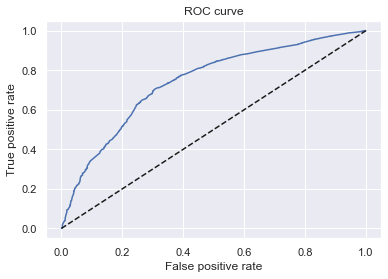

In [131]:
plt.plot(fpr, tpr)
# We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
# thus plotting the ROC curve.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('False positive rate')
# We name the x-axis "False positive rate".
plt.ylabel('True positive rate')
# We name the x-axis "True positive rate".
plt.title('ROC curve')
# We name the graph "ROC curve".

In [132]:
AUROC = roc_auc_score(df_actual_predicted_probs['y_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Calculates the Area Under the Receiver Operating Characteristic Curve (AUROC)
# from a set of actual values and their predicted probabilities.
AUROC

0.7411613117138242

#### Is this value good?

Well, and it's difficult to say because it mostly depends on our data.
Even a model that is built in an excellent way may not be very accurate just because the data provided
are not good enough.
That being said, a common skill for interpretation of area under the curve is this the model is bad 

- bad if AUC is between 50% and 60%
- poor if it is between 60% and 70%,
- fair if it is between 70% and 80% percent 
- good, if it's between 80% and 90%.
- excellent if it's between 90% and 100%

According to that criteria, we can say our model is fair.
But as we said, it is far more important to know to what extent the outcome of interest can be explained by the available information.
This is why typically few competing models are built for every analytical solution with an application in industry when possible.

These competing models are built by different competing models or teams of models.

### Gini and Kolmogorov-Smirnov

#### Criteria for model performance of classification models


The first is the Gini coefficient, while the second Kolmogorov-Smirnov, they are well-established and widely accepted in the credit risk modeling community.

### Gini

In [133]:
df_actual_predicted_probs = df_actual_predicted_probs.sort_values('y_hat_test_proba')
# Sorts a dataframe by the values of a specific column.
df_actual_predicted_probs.head()

,y_test,y_hat_test_proba,y_hat_test
9055,0,0.491910,0
6459,0,0.493437,0
201,1,0.493437,0
12101,0,0.536079,0
2183,1,0.559716,0


In [134]:
df_actual_predicted_probs = df_actual_predicted_probs.reset_index()
# We reset the index of a dataframe and overwrite it.
df_actual_predicted_probs.head()

,index,y_test,y_hat_test_proba,y_hat_test
0,9055,0,0.491910,0
1,6459,0,0.493437,0
2,201,1,0.493437,0
3,12101,0,0.536079,0
4,2183,1,0.559716,0


In [135]:
df_actual_predicted_probs['Cumulative N Population'] = df_actual_predicted_probs.index + 1
# We calculate the cumulative number of all observations.
# We use the new index for that. Since indexing in ython starts from 0, we add 1 to each index.
df_actual_predicted_probs['Cumulative N Good'] = df_actual_predicted_probs['y_test'].cumsum()
# We calculate cumulative number of 'good', which is the cumulative sum of the column with actual observations.
df_actual_predicted_probs['Cumulative N Bad'] = df_actual_predicted_probs['Cumulative N Population'] - df_actual_predicted_probs['y_test'].cumsum()
# We calculate cumulative number of 'bad', which is
# the difference between the cumulative number of all observations and cumulative number of 'good' for each row.

In [136]:
df_actual_predicted_probs.head()

,index,y_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad
0,9055,0,0.491910,0,1,0,1
1,6459,0,0.493437,0,2,0,2
2,201,1,0.493437,0,3,1,2
3,12101,0,0.536079,0,4,1,3
4,2183,1,0.559716,0,5,2,3


In [137]:
df_actual_predicted_probs['Cumulative Perc Population'] = df_actual_predicted_probs['Cumulative N Population'] / (df_actual_predicted_probs.shape[0])
# We calculate the cumulative percentage of all observations.
df_actual_predicted_probs['Cumulative Perc Good'] = df_actual_predicted_probs['Cumulative N Good'] / df_actual_predicted_probs['y_test'].sum()
# We calculate cumulative percentage of 'good'.
df_actual_predicted_probs['Cumulative Perc Bad'] = df_actual_predicted_probs['Cumulative N Bad'] / (df_actual_predicted_probs.shape[0] - df_actual_predicted_probs['y_test'].sum())
# We calculate the cumulative percentage of 'bad'.

In [138]:
df_actual_predicted_probs.head()

,index,y_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Good,Cumulative N Bad,Cumulative Perc Population,Cumulative Perc Good,Cumulative Perc Bad
0,9055,0,0.491910,0,1,0,1,0.000074,0.00000,0.001032
1,6459,0,0.493437,0,2,0,2,0.000148,0.00000,0.002064
2,201,1,0.493437,0,3,1,2,0.000223,0.00008,0.002064
3,12101,0,0.536079,0,4,1,3,0.000297,0.00008,0.003096
4,2183,1,0.559716,0,5,2,3,0.000371,0.00016,0.003096


Text(0.5, 1.0, 'Gini')

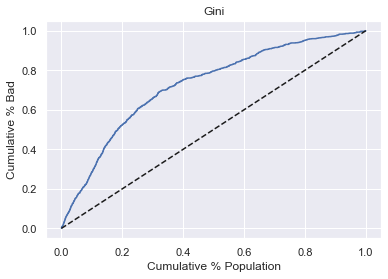

In [139]:
# Plot Gini
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Bad'])
# We plot the cumulative percentage of all along the x-axis and the cumulative percentage 'good' along the y-axis,
# thus plotting the Gini curve.
plt.plot(df_actual_predicted_probs['Cumulative Perc Population'], df_actual_predicted_probs['Cumulative Perc Population'], linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('Cumulative % Population')
# We name the x-axis "Cumulative % Population".
plt.ylabel('Cumulative % Bad')
# We name the y-axis "Cumulative % Bad".
plt.title('Gini')
# We name the graph "Gini".

In [140]:
Gini = AUROC * 2 - 1
# Here we calculate Gini from AUROC.
Gini

0.4823226234276483

Text(0.5, 1.0, 'Kolmogorov-Smirnov')

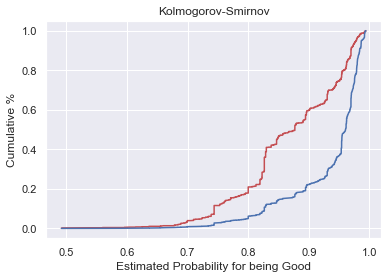

In [141]:
# Plot KS
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Bad'], color = 'r')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'bad' along the y-axis,
# colored in red.
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Good'], color = 'b')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'good' along the y-axis,
# colored in red.
plt.xlabel('Estimated Probability for being Good')
# We name the x-axis "Estimated Probability for being Good".
plt.ylabel('Cumulative %')
# We name the y-axis "Cumulative %".
plt.title('Kolmogorov-Smirnov')
# We name the graph "Kolmogorov-Smirnov".

In [142]:
KS = max(df_actual_predicted_probs['Cumulative Perc Bad'] - df_actual_predicted_probs['Cumulative Perc Good'])
# We calculate KS from the data. It is the maximum of the difference between the cumulative percentage of 'bad'
# and the cumulative percentage of 'good'.
KS

0.39807030912055924